In [1]:
# Import libraries générales
import pandas as pd
import numpy as np

from random import sample
from collections import Counter, defaultdict
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
import seaborn as sns
from umap import UMAP
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# Import data
data_path = "../data/"
df = pd.read_pickle(data_path+"df_2017_avec_auteurs.pkl")

In [3]:
# Choix du corpus
dfh = df[df.rubrique.apply(lambda x : x in set(df.rubrique.head(10)))]
dfhi = dfh.reset_index(drop = True)
corpus = dfh.question
len(corpus)

1780

(154.69494382022472, 78.37497017344054)

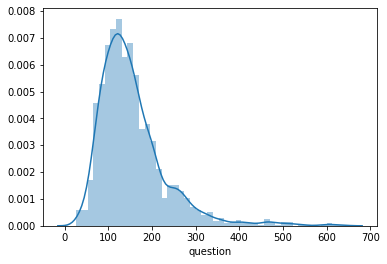

In [4]:
# Nombre moyen de mots dans le corpus
nb_mots = dfh.question.str.split(" ").apply(lambda x : len(x))
sns.distplot(nb_mots, hist=True)
nb_mots.mean(), nb_mots.std()

In [5]:
# Rubriques correspondantes sous forme d'entier
l_r = list(dfh.rubrique.unique())
dic_r = {l_r[i] : i for i in range(len(l_r))}
rubint = dfh.rubrique.apply(lambda x : dic_r[x])

In [6]:
# Groupes correspondants sous forme d'entier
l_g = list(dfh.groupe_auteur.unique())
dic_g = {l_g[i] : i for i in range(len(l_g))}
groupint = dfh.groupe_auteur.apply(lambda x : dic_g[x])

# 1. Vecteurs

## 1.0. TF, TFIDF

In [7]:
# Import for Vectorizer
from stop_words import get_stop_words
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
stop_words = get_stop_words('french')

In [8]:
# Calcul du TF-IF (pour brut, nmf ...)
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
tfidf = tfidf_vectorizer.fit_transform(corpus)
tfidf_vectors = tfidf.toarray()
tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names())

In [9]:
# Calcul du TF (pour LDA)
tf_vectorizer = CountVectorizer(stop_words=stop_words)
tf = tf_vectorizer.fit_transform(corpus)
tf_vectors = tf.toarray()
tf_feature_names = np.array(tf_vectorizer.get_feature_names())

## 1.1 ACP

In [231]:
# Import for PCA
from sklearn.decomposition import PCA

In [232]:
n_components = 20

In [233]:
# PCA TF IDF et graphique ON RANDOM
rand_vectors = np.random.uniform(0,10,tfidf_vectors.shape)
pca_random = PCA(n_components=n_components, random_state=0)
pca_random.fit_transform(rand_vectors);

In [234]:
# PCA TF IDF et graphique
pca = PCA(n_components=n_components, random_state=0)
%time reduced_features_tfidf = pca.fit_transform(tfidf_vectors)

CPU times: user 1.37 s, sys: 36 ms, total: 1.4 s
Wall time: 819 ms


Text(0.5, 1.0, 'Proportion of Explained Variance on random vectors')

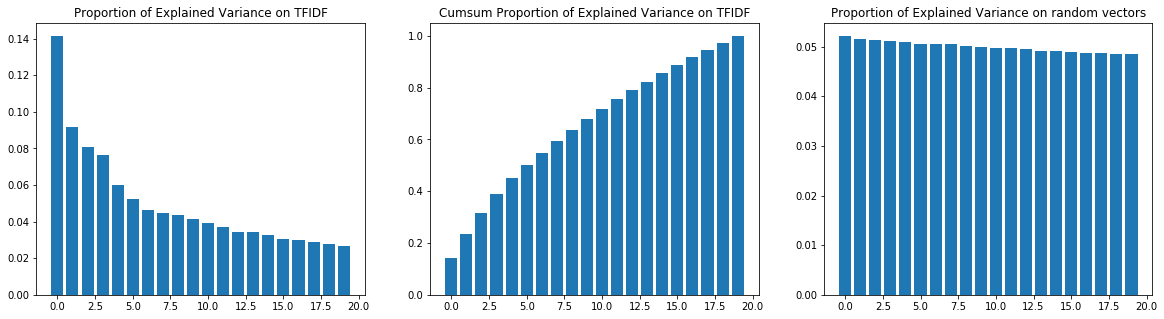

In [57]:
# Comparer les proportions de variance
fig,axes = plt.subplots(1,3,figsize = (20,5))
axes[0].bar(range(len(pca.explained_variance_ratio_)),pca.explained_variance_/pca.explained_variance_.sum())
axes[0].set_title(label = 'Proportion of Explained Variance on TFIDF')
axes[1].bar(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_/pca.explained_variance_.sum()))
axes[1].set_title(label = 'Cumsum Proportion of Explained Variance on TFIDF')
axes[2].bar(range(len(pca_random.explained_variance_ratio_)),pca_random.explained_variance_/pca_random.explained_variance_.sum())
axes[2].set_title(label = 'Proportion of Explained Variance on random vectors')

In [235]:
# PCA TF IDF choisi
k_choisi = 20
pca = PCA(n_components=k_choisi, random_state=0)
%time reduced_features_tfidf = pca.fit_transform(tfidf_vectors)

CPU times: user 1.41 s, sys: 12 ms, total: 1.42 s
Wall time: 836 ms


In [236]:
acp_word_vectors = pca.fit_transform(tfidf_vectors.T).T
top10words_acp = np.array([tfidf_feature_names[(-i).argsort()[:10]] for i in acp_word_vectors])

In [19]:
# PCA TF
random_state = 0
dim_pca_tf = 10
pca = PCA(n_components=dim_pca_tf, random_state=0)
reduced_features_tf = pca.fit_transform(tf_vectors)

In [58]:
def get_acp_doc(k):
    return PCA(n_components=k, random_state=0).fit_transform(tf_vectors)

## 1.2. LSA

In [10]:
from sklearn.decomposition import TruncatedSVD

In [11]:
# Sublinear tf
tfidf_vectorizer_sub = TfidfVectorizer(stop_words=stop_words, sublinear_tf = True)
tfidf_sub = tfidf_vectorizer.fit_transform(corpus)
tfidf_vectors_sub = tfidf.toarray()

In [12]:
dim_lsa = 20
svd_model = TruncatedSVD(n_components=dim_lsa, algorithm='randomized', n_iter=100, random_state=122)
lsa_doc_svd = svd_model.fit_transform(tfidf_sub)
lsa_doc_vectors = lsa_doc_svd

lsa_word_svd = svd_model.fit(tfidf_sub)
lsa_word_vectors = lsa_word_svd.components_

In [13]:
top10words_lsa = np.array([tfidf_feature_names[(-i).argsort()[:10]] for i in lsa_word_vectors])

In [14]:
def get_lsa_doc(k):
    return TruncatedSVD(n_components=k, algorithm='randomized', n_iter=100, random_state=122).fit_transform(tfidf_sub)

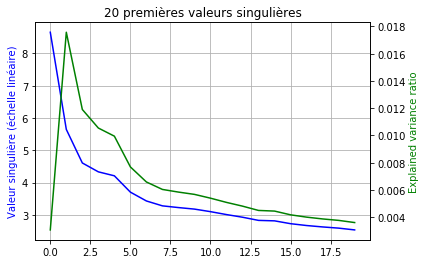

In [24]:
fig, ax = plt.subplots()
ax.plot(svd_model.singular_values_,color = 'blue')
ax.set_ylabel('Valeur singulière (échelle linéaire)',color = 'blue')

ax2 = ax.twinx()
# ax2.plot(lsa_svd.singular_values_, color = 'red')
# ax2.set_ylabel('Valeur singulière (échelle log)',color = 'red')
# ax2.set_yscale('log')

ax2.plot(svd_model.explained_variance_,color = 'green')
ax2.set_ylabel('Explained variance ratio',color = 'green')

ax.grid(True)
ax.set(title='{} premières valeurs singulières'.format(dim_lsa));

In [69]:
K=5
for topic in top10words_acp[:K]:
    print(', '.join(topic),end = ' & ')

maladie, santé, entreprise, pouvoir, charge, mme, prise, public, demande, ministre & maladie, santé, lyme, prise, patient, charge, cancer, malade, atteindre, fibromyalgie & entreprise, cancer, salarié, pourcent, économie, pme, euro, finance, commerce, compte & cancer, enfant, pédiatrique, recherche, école, dépistage, public, financement, décès, euro & école, compte, administration, million, euro, impayer, enseigner, denier, crédibilité, déficit & 

## 1.3. LDA

In [15]:
from sklearn.decomposition import LatentDirichletAllocation

In [16]:
n_topics_lda = 18
lda_doc_model = LatentDirichletAllocation(n_components=n_topics_lda, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf.T)
lda_doc_vectors = lda_doc_model.components_.T

In [17]:
lda_word_model = LatentDirichletAllocation(n_components=n_topics_lda, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tfidf)
lda_word_vectors = lda_word_model.components_

In [18]:
top10words_lda = np.array([tfidf_feature_names[(-i).argsort()[:10]] for i in lda_word_vectors])

In [ ]:
def get_lda_doc(k):
    model =  LatentDirichletAllocation(n_components=k, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf.T)
    return model.components_.T

5 976.9741715315134
7 944.710560470894
8 909.4938820520526
9 924.0428695306882
10 944.8436829727789
11 940.7265502378026
12 935.1806204888779
13 930.2619211895402
14 941.6822102811628
15 926.7074460422809
16 922.4021971724281
17 933.4518182359839
18 924.4341944526388
19 940.7208329352256
20 951.6469458391921
40 1022.3320144896542


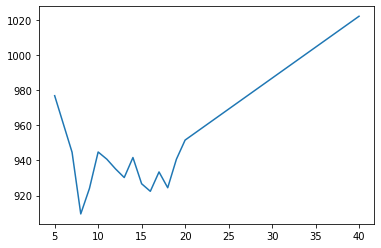

In [80]:
ks = [5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,40]
perps = []
for i,k in enumerate(ks):
    perps.append(LatentDirichletAllocation(n_components=k, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf.T).bound_)
    print(k,perps[-1])
plt.plot(ks,perps)

## 1.4. NMF

In [19]:
from sklearn.decomposition import NMF

In [20]:
n_topics_nmf = 100
nmf_doc_model = NMF(n_components=n_topics_nmf, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf.T)
nmf_doc_vectors = nmf_doc_model.components_.T

In [21]:
nmf_word_model = NMF(n_components=n_topics_nmf, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_word_vectors = nmf_word_model.components_

In [22]:
top10words_nmf = np.array([tfidf_feature_names[(-i).argsort()[:10]] for i in nmf_word_vectors])

In [116]:
def get_nmf_doc(k):
    model = NMF(n_components=k, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf.T)
    return model.components_.T

# 2. Clustering

## 2.1 K-means

In [25]:
# from sklearn.cluster import MiniBatchKMeans

In [26]:
# # Exécution du k-means
# def go_kmeans(vectors, k = 5):
#     random_state = 0
#     kmeans = MiniBatchKMeans(n_clusters=k, random_state=random_state)
#     kmeans.fit(vectors)
#     return kmeans

# # Get the clusters of a kmeans
# def get_clusters_kmeans(vectors, k=5, kmeans = None):
#     if kmeans is None :
#         kmeans = go_kmeans(vectors, k)
#     return kmeans.predict(vectors)

## 2.2 Hiérarchique

In [35]:
# from sklearn.cluster import AgglomerativeClustering

In [36]:
# # Get the clusters of a HAC
# def get_clusters_HAC(vectors, n_clusters, linkage, affinity):
#     aggc = AgglomerativeClustering(linkage=linkage, affinity=affinity, n_clusters=n_clusters)
#     aggc = aggc.fit(vectors)
#     return aggc.labels_

## 2.3 X-means

In [37]:
# from pyclustering.cluster.xmeans import xmeans
# from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
# from pyclustering.cluster import cluster_visualizer

In [73]:
# # Get the clusters of a xmeans
# def execute_xmeans(vecs,kmin,kmax):
#     amount_initial_centers = kmin
#     initial_centers = kmeans_plusplus_initializer(vecs, amount_initial_centers).initialize()

#     xmeans_instance = xmeans(vecs, initial_centers, kmax)
#     xmeans_instance.process()

#     groupes = xmeans_instance.get_clusters()
#     clusters = pd.Series(
#         {j : i for i,m in enumerate(groupes) for j in m}
#     ).sort_index().values
    
#     return clusters